# Demo of Perfect Model Predictability Functions

This demo demonstrates `climpred`'s capabilities for a perfect-model framework ensemble simulation.

**What's a perfect-model framework simulation?**

A perfect-model framework uses a set of ensemble simulations that are based on a General Circulation Model (GCM) or Earth System Model (ESM) alone. There is *no* use of any reanalysis, reconstruction, or data product to initialize the decadal prediction ensemble. An arbitrary number of `members` are initialized from perturbed initial conditions (the "`ensemble`"), and the control simulation can be viewed as just another member.


**How to compare predictability skill score:**
As no observational data interferes with the random climate evolution of the model, we cannot use an observation-based reference for computing skill scores. Therefore, we can compare the members with one another (`m2m`), against the ensemble mean (`m2e`), or against the control (`m2c`). We can also compare the ensemble mean to the control (`e2c`). See the [comparisons](https://climpred.readthedocs.io/en/latest/comparisons.html) page for more information.

**When to use perfect-model frameworks:**

- You don't have a sufficiently long observational record to use as a reference.
- You want to avoid biases between model climatology and reanalysis climatology.
- You want to avoid sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation.
- You want to delve into process understanding of predictability in a model without outside artifacts.

In [1]:
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import climpred

In [2]:
warnings.filterwarnings("ignore")

**Load sample data**

Here we use a subset of ensembles and members from the MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. This corresponds to `vga0214` from year 3000 to 3300.

## 1-dimensional output

Our 1D sample output contains datasets of time series of certain spatially averaged `area` ('global', 'North_Atlantic') and temporally averaged `period` ('ym', 'DJF', ...) for some `lead` years (1, ..., 20).

`ds`: The ensemble dataset of all `members` (1, ..., 10), `inits` (initialization years: 3014, 3023, ..., 3257), `areas`, `periods`, and `lead` years.

`control`: The control dataset with the same areas and periods, as well as the years 3000 to 3299.

In [28]:
ds = climpred.tutorial.load_dataset('MPI-PM-DP-1D').isel(area=1,period=-1)['tos']
control = climpred.tutorial.load_dataset('MPI-control-1D').isel(area=1,period=-1)['tos']

In [29]:
ds['lead'].attrs = {'units': 'years'}

In [30]:
# Add to climpred PerfectModelEnsemble object.
pm = climpred.PerfectModelEnsemble(ds)
pm = pm.add_control(control)
print(pm)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (lead, init, member) float32 ...
Control:
    tos      (time) float32 ...
Uninitialized:
    None


We'll sub-select annual means ('ym') of sea surface temperature ('tos') in the North Atlantic.

### Bootstrapping with Replacement

Here, we bootstrap the ensemble with replacement [Goddard et al. 2013] to compare the initialized ensemble to an "uninitialized" counterpart and a persistence forecast. The visualization is based on those used in [Li et al. 2016]. The p-value demonstrates the probability that the uninitialized or persistence beats the initialized forecast based on N bootstrapping with replacement.

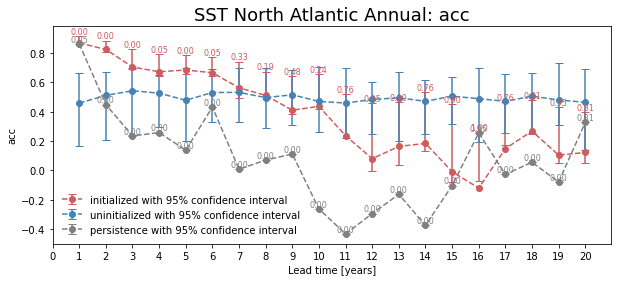

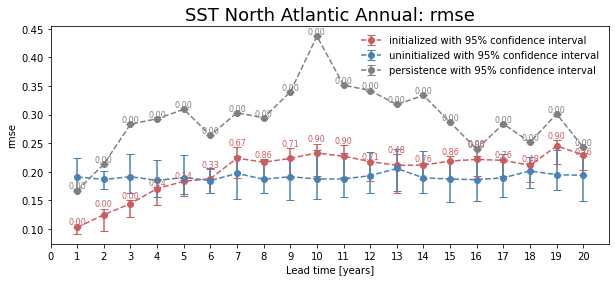

In [31]:
for metric in ['acc', 'rmse']:
    bootstrapped = pm.bootstrap(metric=metric, comparison='m2e', iterations=21, sig=95)
    climpred.graphics.plot_bootstrapped_skill_over_leadyear(bootstrapped)
    plt.title(' '.join(['SST', 'North Atlantic', 'Annual:', metric]),fontsize=18)
    plt.ylabel(metric)
    plt.show()

### Computing Skill with Different Comparison Methods

Here, we use `compute_perfect_model` to compute the Anomaly Correlation Coefficient (ACC) with different comparison methods. This generates different ACC values by design. See the [comparisons](https://climpred.readthedocs.io/en/latest/comparisons.html) page for a description of the various ways to compute skill scores for a perfect-model framework.

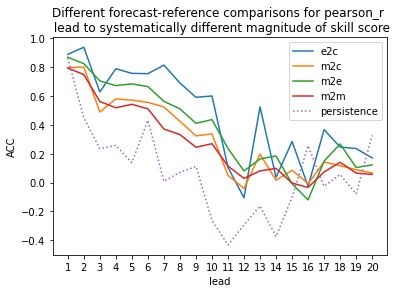

In [32]:
for c in ['e2c','m2c','m2e','m2m']:
    pm.compute_metric(metric='acc', comparison=c)['tos'].plot(label=c)
# Persistence computation for a baseline.
pm.compute_persistence(metric='acc')['tos'].plot(label='persistence', ls=':')
plt.ylabel('ACC')
plt.xticks(np.arange(1,21))
plt.legend()
plt.title('Different forecast-reference comparisons for pearson_r \n lead to systematically different magnitude of skill score')
plt.show()

## 3-dimensional output (maps)

We also have some sample output that contains gridded time series on the curvilinear MPI grid. Our compute functions (`compute_perfect_model`, `compute_persistence`) are indifferent to any dimensions that exist in addition to `init`, `member`, and `lead`. In other words, the functions are set up to make these computations on a grid, if one includes `lat`, `lon`, `lev`, `depth`, etc.

`ds3d`: The ensemble dataset of `members` (1, 2, 3, 4), `inits` (initialization years: 3014, 3061, 3175, 3237), and `lead` years (1, 2, 3, 4, 5).

`control3d`: The control dataset spanning (3000, ..., 3049).

**Note**: These are very small subsets of the actual MPI simulations so that we could host the sample output maps on Github.

In [33]:
# Sea surface temperature
ds3d = climpred.tutorial.load_dataset('MPI-PM-DP-3D') \
                        .sel(init=3014) \
                        .expand_dims('init')['tos']
control3d = climpred.tutorial.load_dataset('MPI-control-3D')['tos']

In [34]:
ds3d['lead'].attrs = {'units': 'years'}

In [35]:
# Create climpred PerfectModelEnsemble object.
pm = climpred.PerfectModelEnsemble(ds3d)
pm = pm.add_control(control3d)
print(pm)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (init, lead, member, y, x) float32 nan nan nan nan ... nan nan nan
Control:
    tos      (time, y, x) float32 ...
Uninitialized:
    None


### Maps of Skill by Lead Year

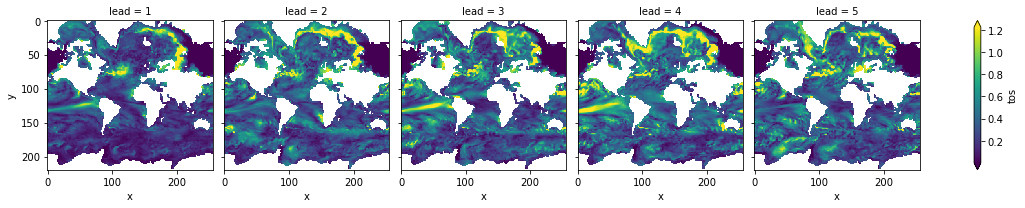

In [36]:
pm.compute_metric(metric='rmse', comparison='m2e')['tos'] \
  .T.plot(col='lead', robust=True, yincrease=False)

## References

1. Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
1. Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
1. Goddard, Lisa, et al. "A verification framework for interannual-to-decadal predictions experiments." Climate Dynamics 40.1-2 (2013): 245-272.
1. Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
1. Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
1. Li, Hongmei, Tatiana Ilyina, Wolfgang A. Müller, and Frank Sienz. “Decadal Predictions of the North Atlantic CO2 Uptake.” Nature Communications 7 (March 30, 2016): 11076. https://doi.org/10/f8wkrs.
1. Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.